In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd

In [2]:
def get_periods(db_conn):
    """
    This function returns a list of simulated
    years.
    """

    command = "SELECT * FROM time_periods WHERE flag is 'f'"

    cur = db_conn.cursor()
    cur.execute(command)
    periods = [y[0] for y in cur.fetchall()]

    return periods[:-1]
def get_regional_techs(db_conn, outcomm, region):
    """
    This function returns a list of technologies
    in a given sector.
    """

    cur = db_conn.cursor()

    if type(outcomm) == list:
        command = (f"SELECT tech FROM Output_VFlow_Out WHERE regions LIKE '%{region}' "
                   f"AND (output_comm IS '{outcomm[0]}' OR output_comm IS '{outcomm[1]}')" )
    else:
        command = (f"SELECT tech FROM Output_VFlow_Out WHERE regions LIKE '%{region}' "
                   f"AND output_comm IS '{outcomm}' ")


    cur.execute(command)

    regional_techs = np.unique([t[0] for t in cur.fetchall()])

    return regional_techs
def get_annual_capacity(db_conn, region, outcomm, scenario=None):
    """
    Retrieves the annual capacity of each technology.
    """

    periods = get_periods(db_conn)
    all_techs = get_regional_techs(db_conn, outcomm, region)

    cur = db_conn.cursor()

    cap_dict = {}
    for tech in all_techs:
        if scenario == None:
            command = (f"SELECT t_periods, capacity "
                       f"FROM Output_CapacityByPeriodAndTech "
                       f"WHERE tech IS '{tech}' "
                       f"AND regions LIKE '%{region}' "
                       f"ORDER BY Output_CapacityByPeriodAndTech.t_periods")
        else:
            command = (f"SELECT t_periods, capacity "
                       f"FROM Output_CapacityByPeriodAndTech "
                       f"WHERE tech IS '{tech}' "
                       f"AND regions LIKE '%{region}' "
                       f"AND scenario LIKE '%{scenario}' "
                       f"ORDER BY Output_CapacityByPeriodAndTech.t_periods")
        cur.execute(command)
        cap_tech = cur.fetchall()

        diff = np.diff(periods).astype('int')[0]
        first_year = int(min(periods))

        caps = np.zeros(len(periods))
        for i, tup in enumerate(cap_tech):
            year = tup[0]
            cap = tup[1]
            j = int((year-first_year)/diff)
            caps[j] = cap
        cap_dict[tech] = caps
    cap_dict['year'] = periods

    cap_df = pd.DataFrame(cap_dict)
    cap_df.set_index('year', inplace=True)
    return cap_df
def get_annual_generation(db_conn, region, outcomm, scenario=None):
    """
    Retrieves the annual generation of each technology.
    """

    periods = get_periods(db_conn)
    all_techs = get_regional_techs(db_conn, outcomm, region)

    cur = db_conn.cursor()

    cap_dict = {}
    for tech in all_techs:
        if scenario == None:
            command = (f"SELECT t_periods, SUM(vflow_out), tech "
                           f"FROM Output_VFlow_Out "
                           f"WHERE tech IS '{tech}' "
                           f"AND regions LIKE '%{region}' "
                           f"GROUP BY Output_VFlow_Out.t_periods")
        else:
            command = (f"SELECT t_periods, SUM(vflow_out), tech "
                           f"FROM Output_VFlow_Out "
                           f"WHERE tech IS '{tech}' "
                           f"AND regions LIKE '%{region}' "
                           f"AND scenario LIKE '%{scenario}' "
                           f"GROUP BY Output_VFlow_Out.t_periods")
        cur.execute(command)
        cap_tech = cur.fetchall()

        diff = np.diff(periods).astype('int')[0]
        first_year = int(min(periods))

        caps = np.zeros(len(periods))
        for i, tup in enumerate(cap_tech):
            year = tup[0]
            cap = tup[1]
            j = int((year-first_year)/diff)
            caps[j] = cap
        cap_dict[tech] = caps
    cap_dict['year'] = periods

    cap_df = pd.DataFrame(cap_dict)
    cap_df.set_index('year', inplace=True)
    return cap_df

In [3]:
path = 'pygen_test/bakery_test_kitchen_02.sqlite'
conn = sqlite3.connect(path)
cursor = conn.cursor()

In [4]:
command = "SELECT total_system_cost FROM Output_Objective"
cursor.execute(command)
res = cursor.fetchall()

print(f'Objective Function Value = ${round(res[0][0],3)}')

Objective Function Value = $4005.176


In [5]:
df = get_annual_capacity(conn, 'MyBakery', 'COOKIES', scenario='test_kitchen')
gdf= get_annual_generation(conn, 'MyBakery', 'DOUGH', scenario='test_kitchen')

In [6]:
list_items = ['DOUGH', 'COOKIES_DEM', 'EGG', 'FLOUR', 'SUGAR', 'BUTTER', 'COOKIES']
for item in list_items:
    print(get_annual_generation(conn, 'MyBakery', item, scenario='test_kitchen'))

      MIXER_ELC
year           
2020      100.0
2021      100.0
            STORE
year             
2020  4799.999997
2021  4799.999997
      IMP_EGG
year         
2020   25.075
2021   25.075
         IMP_FLR
year            
2020  200.175001
2021  200.175001
      IMP_SGR
year         
2020   99.875
2021   99.875
      IMP_BTR
year         
2020   99.875
2021   99.875
       CONV_OVEN  REFRIGERATOR
year                          
2020  4800.00002   3508.782461
2021  4800.00002   3508.782461


<AxesSubplot:xlabel='year'>

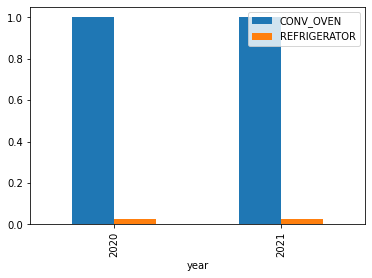

In [7]:
fig, ax = plt.subplots(figsize=(6,4), facecolor='w', edgecolor='k')
df.plot.bar(ax=ax)